# Airbnb Price Prediction

## 1. Data Wrangling


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scipy.stats import chi2_contingency, zscore

import requests
import time
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df = pd.read_csv("data/AirbnbPrice.csv", encoding="ISO-8859-1")

In [3]:
df.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [4]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

## 1.1 Clean-up Categorical Features

In [6]:
# Convert date columns
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

In [7]:
object_columns = df.select_dtypes(include=['object']).columns

for col in object_columns:
    print(f'{col}: {df[col].nunique()}')

property_type: 35
room_type: 3
amenities: 67122
bed_type: 5
cancellation_policy: 5
city: 6
description: 73472
host_has_profile_pic: 2
host_identity_verified: 2
host_response_rate: 80
instant_bookable: 2
name: 73269
neighbourhood: 619
thumbnail_url: 65883
zipcode: 669


In [8]:
df['host_response_rate']

0         NaN
1        100%
2        100%
3         NaN
4        100%
         ... 
74106     NaN
74107    100%
74108    100%
74109    100%
74110    100%
Name: host_response_rate, Length: 74111, dtype: object

In [9]:
# Remove '%' symbol and convert to numeric
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float) / 100

In [10]:
df['host_response_rate'].dtypes

dtype('float64')

In [11]:
df[['instant_bookable', 'host_has_profile_pic', 'host_identity_verified', 'property_type', 'room_type', 'cancellation_policy', 'city', 'neighbourhood']].head()

,instant_bookable,host_has_profile_pic,host_identity_verified,property_type,room_type,cancellation_policy,city,neighbourhood
0,f,t,t,Apartment,Entire home/apt,strict,NYC,Brooklyn Heights
1,t,t,f,Apartment,Entire home/apt,strict,NYC,Hell's Kitchen
2,t,t,t,Apartment,Entire home/apt,moderate,NYC,Harlem
3,f,t,t,House,Entire home/apt,flexible,SF,Lower Haight
4,t,t,t,Apartment,Entire home/apt,moderate,DC,Columbia Heights


In [12]:
df['instant_bookable'] = df['instant_bookable'].astype('category')
df['host_has_profile_pic'] = df['host_has_profile_pic'].astype('category')
df['host_identity_verified'] = df['host_identity_verified'].astype('category')
df['property_type'] = df['property_type'].astype('category')
df['room_type'] = df['room_type'].astype('category')
df['bed_type'] = df['bed_type'].astype('category')
df['cancellation_policy'] = df['cancellation_policy'].astype('category')
df['city'] = df['city'].astype('category')
df['neighbourhood'] = df['neighbourhood'].astype('category')
df['zipcode'] = df['zipcode'].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      74111 non-null  int64         
 1   log_price               74111 non-null  float64       
 2   property_type           74111 non-null  category      
 3   room_type               74111 non-null  category      
 4   amenities               74111 non-null  object        
 5   accommodates            74111 non-null  int64         
 6   bathrooms               73911 non-null  float64       
 7   bed_type                74111 non-null  category      
 8   cancellation_policy     74111 non-null  category      
 9   cleaning_fee            74111 non-null  bool          
 10  city                    74111 non-null  category      
 11  description             74111 non-null  object        
 12  first_review            58247 non-null  dateti

## 1.2 Identify and Handle Missing Values

In [14]:
missing = df.isnull().sum()
print(missing[missing > 0])

bathrooms                   200
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
last_review               15827
neighbourhood              6872
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64


In [15]:
# 1. Drop non-informational columns
df = df.drop(columns=['thumbnail_url', 'id', 'name'])

In [16]:
# 1. KNN imputation for 'bedrooms' using 'beds' and 'bathrooms' as features
features_for_bedrooms_imputation = ['beds', 'bathrooms']
imputer_bedrooms = KNNImputer(n_neighbors=5)

# Select only rows where 'bedrooms' is missing, so that only missing values are imputed
df_bedrooms = df[features_for_bedrooms_imputation].copy()
imputed_bedrooms = imputer_bedrooms.fit_transform(df_bedrooms)

# Replace only the missing values in 'bedrooms' column with imputed values
df.loc[df['bedrooms'].isna(), 'bedrooms'] = imputed_bedrooms[df['bedrooms'].isna(), 0]

# 2. KNN imputation for 'beds' using 'bedrooms' and 'bathrooms' as features
features_for_beds_imputation = ['bedrooms', 'bathrooms']
imputer_beds = KNNImputer(n_neighbors=5)

df_beds = df[features_for_beds_imputation].copy()
imputed_beds = imputer_beds.fit_transform(df_beds)

# Replace only the missing values in 'beds' column with imputed values
df.loc[df['beds'].isna(), 'beds'] = imputed_beds[df['beds'].isna(), 0]

# 3. KNN imputation for 'bathrooms' using 'beds' and 'bedrooms' as features
features_for_bathrooms_imputation = ['beds', 'bedrooms']
imputer_bathrooms = KNNImputer(n_neighbors=5)

df_bathrooms = df[features_for_bathrooms_imputation].copy()
imputed_bathrooms = imputer_bathrooms.fit_transform(df_bathrooms)

# Replace only the missing values in 'bathrooms' column with imputed values
df.loc[df['bathrooms'].isna(), 'bathrooms'] = imputed_bathrooms[df['bathrooms'].isna(), 0]

In [17]:
df.describe()

,log_price,accommodates,bathrooms,host_response_rate,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,74111.000000,74111.000000,74111.000000,55812.000000,74111.000000,74111.000000,74111.000000,57389.000000,74111.000000,74111.000000
mean,4.782069,3.155146,1.235129,0.943520,38.445958,-92.397525,20.900568,94.067365,1.265825,1.709834
std,0.717394,2.153589,0.581932,0.163418,3.080167,21.705322,37.828641,7.836556,0.851795,1.253444
min,0.000000,1.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,4.317488,2.000000,1.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,4.709530,2.000000,1.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,5.220356,4.000000,1.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,7.600402,16.000000,8.000000,1.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   log_price               74111 non-null  float64       
 1   property_type           74111 non-null  category      
 2   room_type               74111 non-null  category      
 3   amenities               74111 non-null  object        
 4   accommodates            74111 non-null  int64         
 5   bathrooms               74111 non-null  float64       
 6   bed_type                74111 non-null  category      
 7   cancellation_policy     74111 non-null  category      
 8   cleaning_fee            74111 non-null  bool          
 9   city                    74111 non-null  category      
 10  description             74111 non-null  object        
 11  first_review            58247 non-null  datetime64[ns]
 12  host_has_profile_pic    73923 non-null  catego

In [19]:
# # Filter rows where 'review_scores_rating', 'host_response_rate', 'first_review', and 'last_review' are all missing
missing_count = df[
    df['host_response_rate'].isnull() &
    df['review_scores_rating'].isnull() &
    df['first_review'].isnull() &
    df['last_review'].isnull()
].shape[0]

print('Number of listings with no review dates, ratings, and response rates:', missing_count)

Number of listings with no review dates, ratings, and response rates: 8418


* This code identifies listings that are likely newly registered by checking if there is no review or rating information (first_review, last_review, review_scores_rating, and response rates are all missing). When these three columns have null values, it suggests that the listing has not yet received any customer reviews, which often happens with new listings.

* The next code creates a new binary column, is_new_listing, and assigns it a value of 1 if the listing is likely new (i.e., has no review dates or ratings) and 0 otherwise. This feature helps the model recognize which listings are newly registered, enabling it to account for the absence of customer feedback when predicting price. This adjustment may improve the model's ability to handle cases with missing review information and make more accurate predictions for new listings.

In [20]:
# Add a new column to indicate if the listing is new (no reviews or ratings)
df['is_new_listing'] = (
    df['host_response_rate'].isnull() &
    df['review_scores_rating'].isnull() &
    df['first_review'].isnull() &
    df['last_review'].isnull()
).astype(int)

In [21]:
# 2.2 Other Imputations with median
df['review_scores_rating'].fillna(df['review_scores_rating'].median(), inplace=True)
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)

* Given that both first_review and last_review columns have a significant amount of missing data—15,864 and 15,862 entries out of 74,111 respectively—imputation would be complex and could introduce bias. Additionally, we have the host_since column, which provides information on the host's duration on the platform, allowing us to approximate their activity period. As these two columns do not add substantial value in the presence of host_since, we will remove them from the dataset to reduce complexity and streamline the data preprocessing.

In [22]:
# 3. drop review dates columns
df.drop(columns=['first_review', 'last_review'], inplace=True)

In [23]:
# 4. Fill missing values in categorical columns with mode
df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0], inplace=True)
df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True)
df['host_since'].fillna(df['host_since'].mode()[0], inplace=True)

* The "neighbourhood" column contains 6,485 missing values. Imputation of these missing values is possible through a classification model using latitude and longitude as features.

In [24]:
# Filter out rows where 'neighbourhood' is missing to train the model
train_data = df[df['neighbourhood'].notna()]

# Features: latitude, longitude
X_train = train_data[['latitude', 'longitude']]

# Target: neighbourhood (categorical)
y_train = train_data['neighbourhood']

# Train a RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.4f}")

# Predict the missing neighbourhood values
missing_data = df[df['neighbourhood'].isna()]
X_missing = missing_data[['latitude', 'longitude']]

# Predict neighbourhood for the missing rows
predictions = model.predict(X_missing)

# Fill the missing neighbourhood values with the predictions
df.loc[df['neighbourhood'].isna(), 'neighbourhood'] = predictions

# Check if the missing values have been filled
print(f"Number of missing values in 'neighbourhood' after imputation: {df['neighbourhood'].isna().sum()}")

Training accuracy: 0.8417
Number of missing values in 'neighbourhood' after imputation: 0


In [25]:
'''
# 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")
'''

'\n# 5-fold cross-validation\ncv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=\'accuracy\')\n\n# Cross-validation results\nprint(f"Cross-validation scores: {cv_scores}")\nprint(f"Mean cross-validation score: {cv_scores.mean():.4f}")\n'

* Zipcode can also be imputed in the same way using longitude and latitude

In [26]:
train_data = df[df['zipcode'].notna()]

X_train = train_data[['latitude', 'longitude']]
y_train = train_data['zipcode']

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_accuracy:.4f}")

missing_data = df[df['zipcode'].isna()]
X_missing = missing_data[['latitude', 'longitude']]

predictions = model.predict(X_missing)

df.loc[df['zipcode'].isna(), 'zipcode'] = predictions

print(f"Number of missing values in 'zipcode' after imputation: {df['zipcode'].isna().sum()}")

Training accuracy: 0.8284
Number of missing values in 'zipcode' after imputation: 0


In [27]:
'''
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")
'''

'\ncv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=\'accuracy\')\n\nprint(f"Cross-validation scores: {cv_scores}")\nprint(f"Mean cross-validation score: {cv_scores.mean():.4f}")\n'

In [28]:
df.isnull().sum()

log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
latitude                  0
longitude                 0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
zipcode                   0
bedrooms                  0
beds                      0
is_new_listing            0
dtype: int64

## 1.3 Checking duplicated rows

In [29]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

Number of duplicated rows: 0


# 2. Exploratory Data Analysis

## 2.1 Univariate Analysis

### 2.1.1 Distribution of numerical features

In [30]:
import math

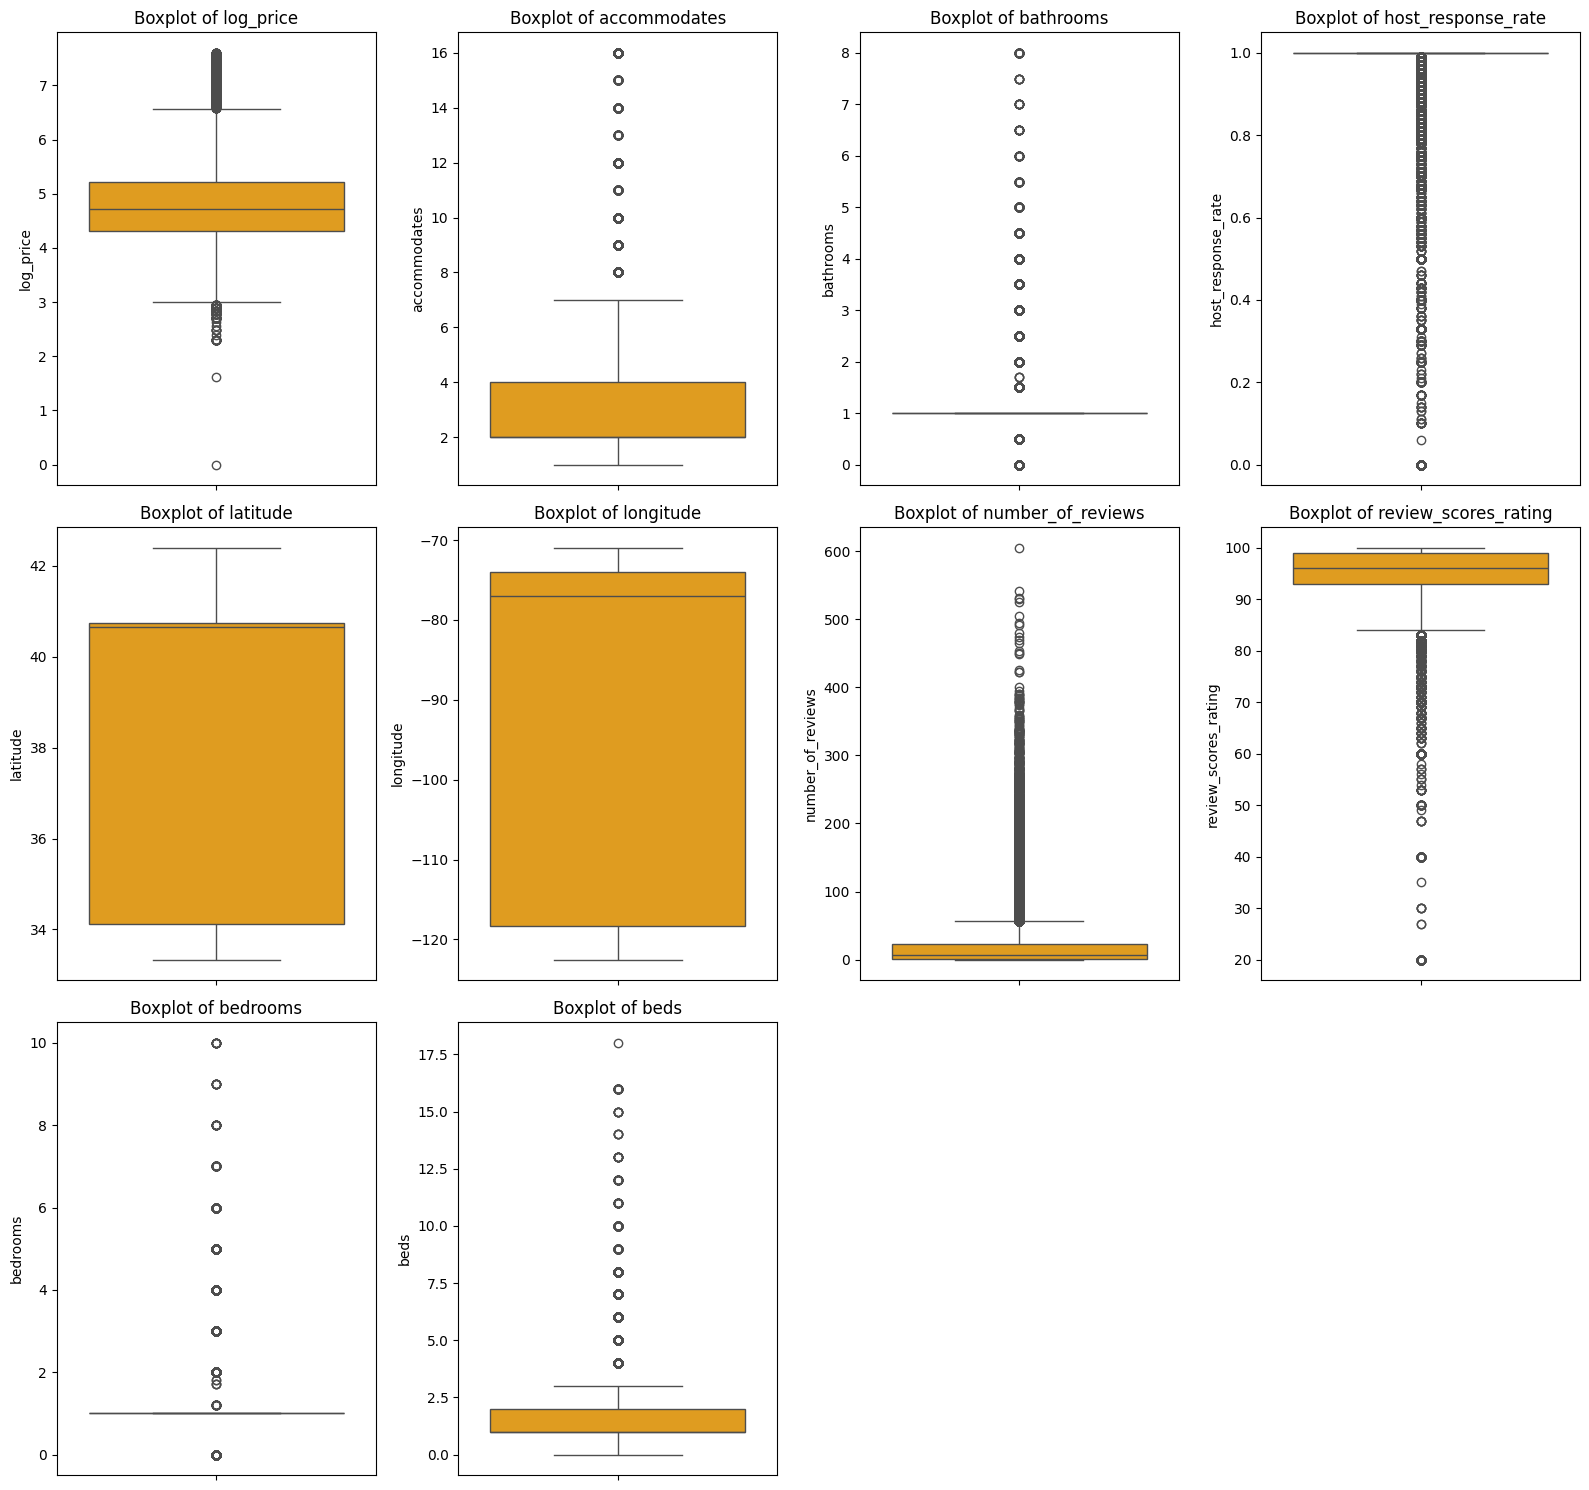

In [31]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Set the number of columns for layout
n_cols = 4
n_rows = math.ceil(len(numerical_cols) / n_cols)

# Set up the plot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each numerical feature
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, y=col, color='orange', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

* Outliers with prices below 10 dollars may be excluded from the dataset due to potential data entry errors.

In [32]:
df= df[df['log_price'] >= 2.302585]

* Looking at the distribution of the numerical features, it appears that several features are skewed, and there seem to be outliers, but there are no values that seem impossible. How to handle the outliers will be determined later based on the relationships with other variables.

### 2.1.2 Distribution of categorical features

In [33]:
categorical_features = df.select_dtypes(include=['category']).columns
categorical_features


Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
       'host_has_profile_pic', 'host_identity_verified', 'instant_bookable',
       'neighbourhood', 'zipcode'],
      dtype='object')

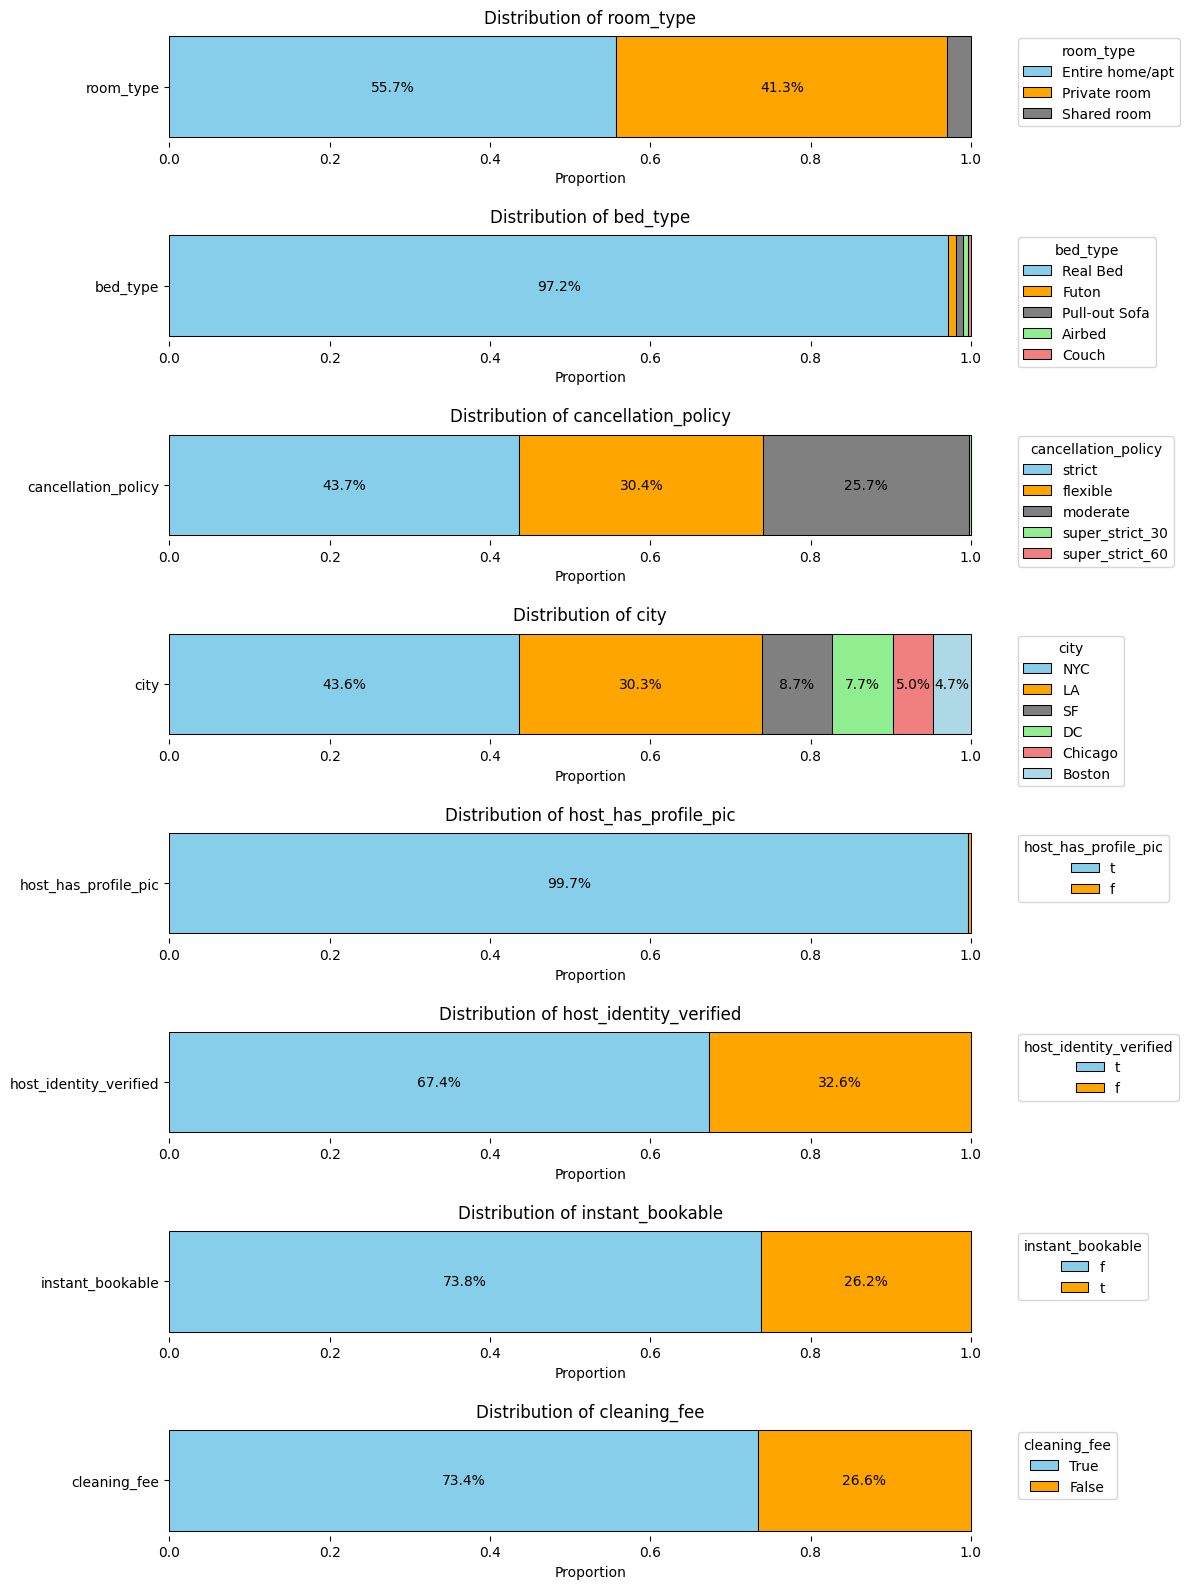

In [34]:
# List of categorical features to plot
categorical_features = ['room_type', 'bed_type', 'cancellation_policy', 'city',
                        'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'cleaning_fee']

# Colors for each category
colors = ['skyblue', 'orange', 'gray', 'lightgreen', 'lightcoral', 'lightblue', 'yellow']

# Adjust the figure size to ensure enough space for all plots
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(12, 2 * len(categorical_features)))

# Flatten axes array for easier iteration
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    # Sort by proportion in descending order
    category_counts = df[feature].value_counts(normalize=True).sort_values(ascending=False)

    bottom = 0  
    ax = axes[i] 

    # Draw the stacked bar chart
    for j, category in enumerate(category_counts.index):
        proportion = category_counts[category]
        ax.barh(feature, proportion, left=bottom, color=colors[j % len(colors)], edgecolor='black', linewidth=0.75)
        bottom += proportion

    ax.set_xlabel('Proportion')  # Label for x-axis
    ax.set_title(f'Distribution of {feature}')  # Title for each plot

    # Add percentage labels
    bottom = 0
    for j, category in enumerate(category_counts.index):
        proportion = category_counts[category]
        if proportion * 100 > 4.5:  # Only display labels for values greater than 4.5%
            ax.text(bottom + proportion / 2, 0, f'{proportion * 100:.1f}%', ha='center', va='center', fontsize=10)
        bottom += proportion  # Update the bottom for the next segment

    # Remove chart borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add legend
    ax.legend(category_counts.index, title=feature, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(hspace=0.8)

* Most room types are either "Entire home/apt" or "Private room."
* The "Bed Type" feature in the dataset shows that "Real Bed" is by far the most common, accounting for nearly all listings. In fact, the remaining bed types—such as "Futon," "Pull-out Sofa," "Airbed," and "Couch"—collectively make up only 2.8% of listings. Removing the bed_type feature simplifies the dataset, allowing us to focus on features with more balanced distributions and potentially meaningful impact.
* The cancellation policy with the highest proportion is "Strict" at 43.7%, followed by "Flexible" at 30.4% and "Moderate" at 25.7%.
* New York has the highest representation among locations at 43.6%, followed by Los Angeles(30.3%), San Francisco(8.7%), DC(7.7%), Chicago(5.0%), and Boston(4.7%).
* Nearly all hosts (99.7%) have a profile picture. It means that this feature shows very little variance. It may be that this variable is effectively saturated, meaning most hosts already meet this condition, leaving little room for this factor to impact other analyses significantly. Thus, I could remove this feature from dataset.
* The ratio of identity-verified hosts to non-verified hosts is approximately 6.5 to 3.5.
* With 73.8% of listings being instant bookable and the remaining 26.2% requiring host approval, this feature could provide insights into booking flexibility preferences among hosts.

In [35]:
df.drop(columns=['bed_type', 'host_has_profile_pic'], inplace=True)

In [36]:
df['property_type'].unique()

['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse', ..., 'Parking Space', 'Train', 'Cave', 'Lighthouse', 'Island']
Length: 35
Categories (35, object): ['Apartment', 'Bed & Breakfast', 'Boat', 'Boutique hotel', ..., 'Treehouse', 'Vacation home', 'Villa', 'Yurt']

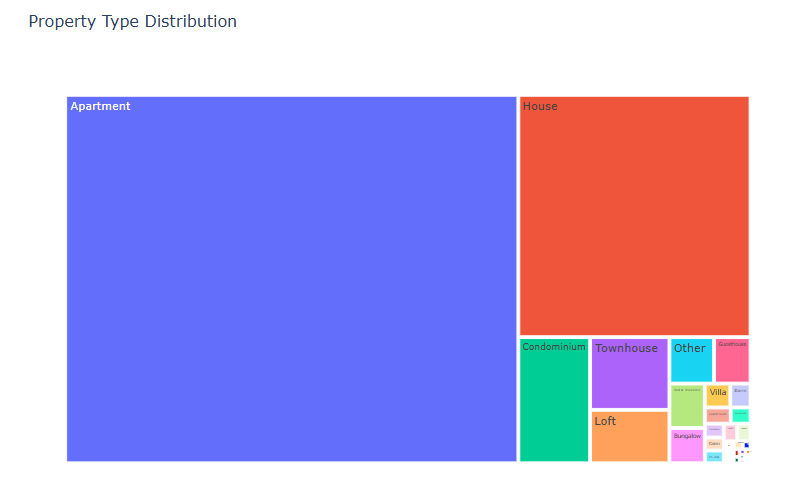

In [37]:
'''
import plotly.express as px

# Calculate proportions for 'property_type' and create a new DataFrame
property_counts = df['property_type'].value_counts(normalize=True).reset_index()
property_counts.columns = ['property_type', 'proportion']

# Create a treemap with proportional sizes and larger figure layout
fig = px.treemap(property_counts, path=['property_type'], values='proportion', 
                 title="Property Type Distribution")

# Increase figure size
fig.update_layout(width=900, height=600)

fig.show()
'''
from IPython.display import Image

Image(filename="PropertyType_Treemap.png")

* The property_type feature is heavily skewed, with 66.1% of listings as "Apartment," 22.3% as "House," 3.6% as "Condominium," and 2.3% as "Townhouse," leaving 31 other types with minimal representation. To simplify analysis and focus on major categories, we'll group these into "Apartment," "House," "Condo_Townhouse," and "Other."

In [38]:
df['property_type'] = df['property_type'].apply(lambda x: 
    'Apartment' if x == 'Apartment' else
    'House' if x == 'House' else
    'Condo_Townhouse' if x in ['Condominium', 'Townhouse'] else
    'Other'
)

print(df['property_type'].value_counts(normalize=True) * 100)

Apartment          66.121524
House              22.279345
Condo_Townhouse     5.868383
Other               5.730748
Name: property_type, dtype: float64


## 2.2 Bivariate Analysis

### 2.2.1 Correlation Analysis

#### 2.2.1.1 Correlation among numerical features

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

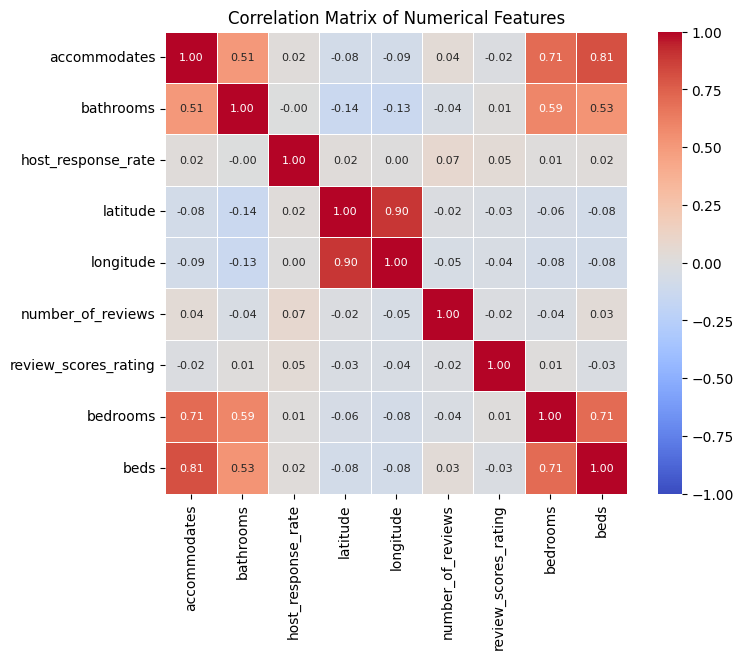

In [39]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).iloc[:, 1:]
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")

* Currently, we observe a relatively high correlation between several numerical features, particularly among accommodates, bedrooms, and beds. This is an intuitive result, as these features are often closely related in property listings. However, the high correlation, especially with values above 0.7, may indicate potential multicollinearity issues, which can cause problems in linear models like regression, leading to unstable coefficient estimates.
* Therefore, it may be necessary to reduce features with high correlation through feature selection methods in the future.

#### 2.2.1.2 Redundancy among categorical features

The 'zipcode' and 'neighbourhood' categorical features are likely to contain similar information, so a Chi-square test was conducted to assess the independence of the two features.

In [40]:
df[['zipcode', 'neighbourhood']].nunique()

zipcode          669
neighbourhood    619
dtype: int64

In [41]:
# Cross-tabulate zipcode and neighbourhood
cross_tab = pd.crosstab(df['zipcode'], df['neighbourhood'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(cross_tab)

# Display p-value to check for independence
print(f"Chi-square p-value: {p}")

Chi-square p-value: 0.0


* As a result of the Chi-square test on the 'zipcode' and 'neighbourhood' features, the p-value of 0.0 indicates that there is a statistically significant relationship between the two variables.
* Since the p-value is extremely small (less than the typical threshold of 0.05), we can reject the null hypothesis that the two variables are independent. This suggests that the 'zipcode' and 'neighbourhood' features are not independent, and there is some dependency or association between them.
* In practical terms, this means that 'zipcode' and 'neighbourhood' likely share similar or overlapping information. Therefore, using both features in the model might result in redundancy, and it could be worth considering combining or selecting one of them to avoid multicollinearity or unnecessary complexity in the model.

### 2.2.2 Numerical features vs target variable

#### 2.2.2.1 Non-continuous numerical features vs target variable

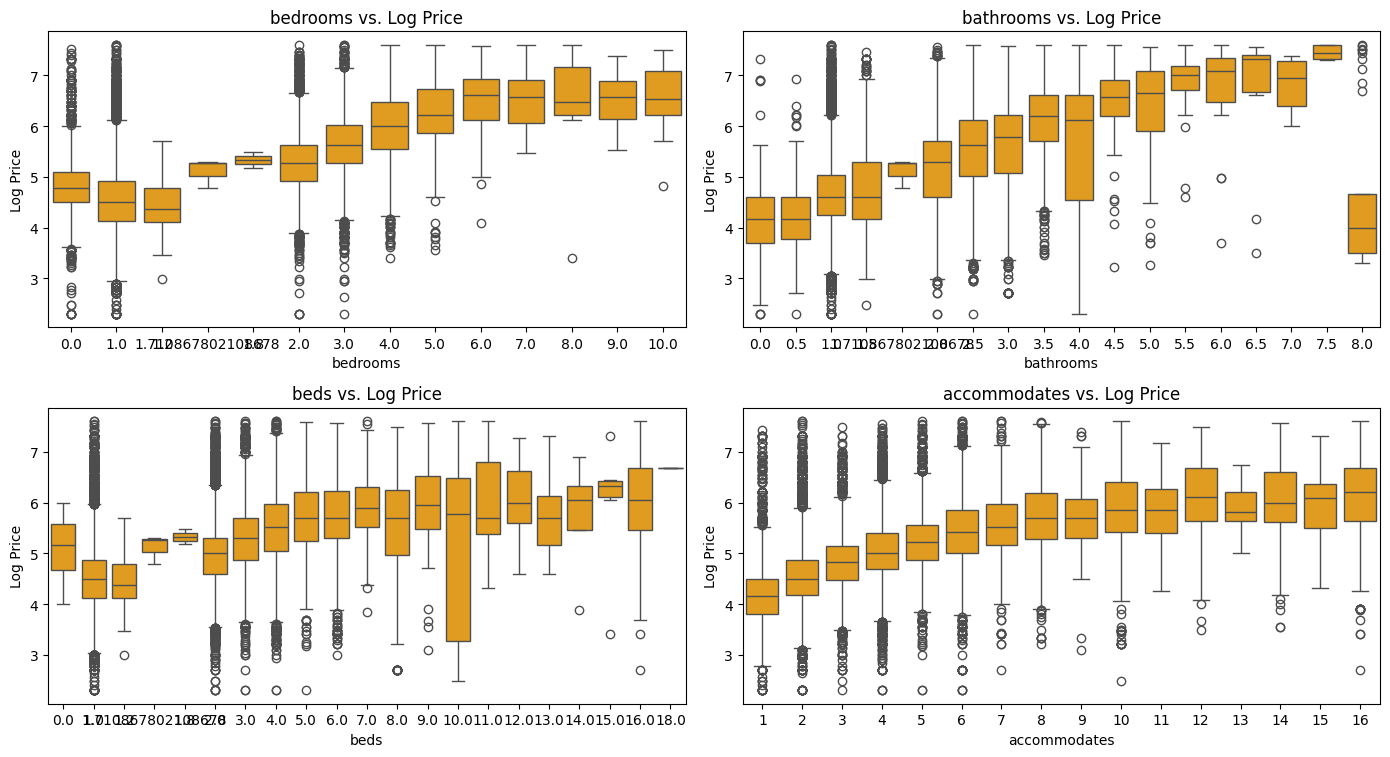

In [42]:
numerical_features = ['bedrooms', 'bathrooms', 'beds', 'accommodates']

n_cols = 2
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))

axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], y=df['log_price'], ax=axes[i], color='orange')
    axes[i].set_title(f'{feature} vs. Log Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Log Price')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])


Text(0.5, 1.0, 'Room Type Distribution for Properties with 8 Bathrooms')

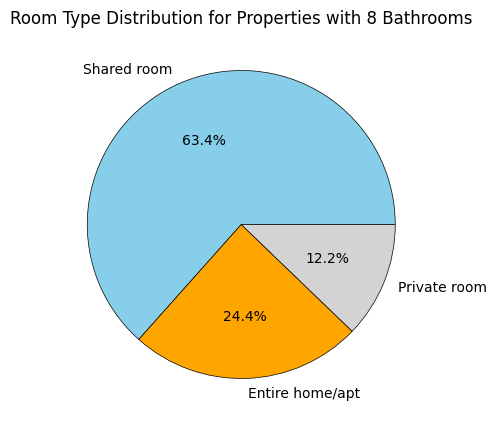

In [43]:
bathrooms_8 = df[df['bathrooms'] == 8]

room_type_counts = bathrooms_8['room_type'].value_counts()

colors = ['skyblue', 'orange', 'lightgray']

plt.figure(figsize=(5, 5))
plt.pie(room_type_counts, labels=room_type_counts.index, autopct='%1.1f%%', 
        colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})

# Title
plt.title('Room Type Distribution for Properties with 8 Bathrooms')

* The features bedrooms, bathrooms, beds, and accommodates generally show a clear relationship with log_price. 
* However, as feature values increase, the change in the target variable tends to become more gradual.
* For bathrooms, there is a significant drop in price at the highest value of 8.
* When the number of bedrooms is 8, as seen in the pie chart above, the high proportion of shared rooms (63.4%) seems to be a factor contributing to the lower prices. This suggests that the interaction between room type and other variables is important.

#### 2.2.2.2 Continuous numerical features vs target variable

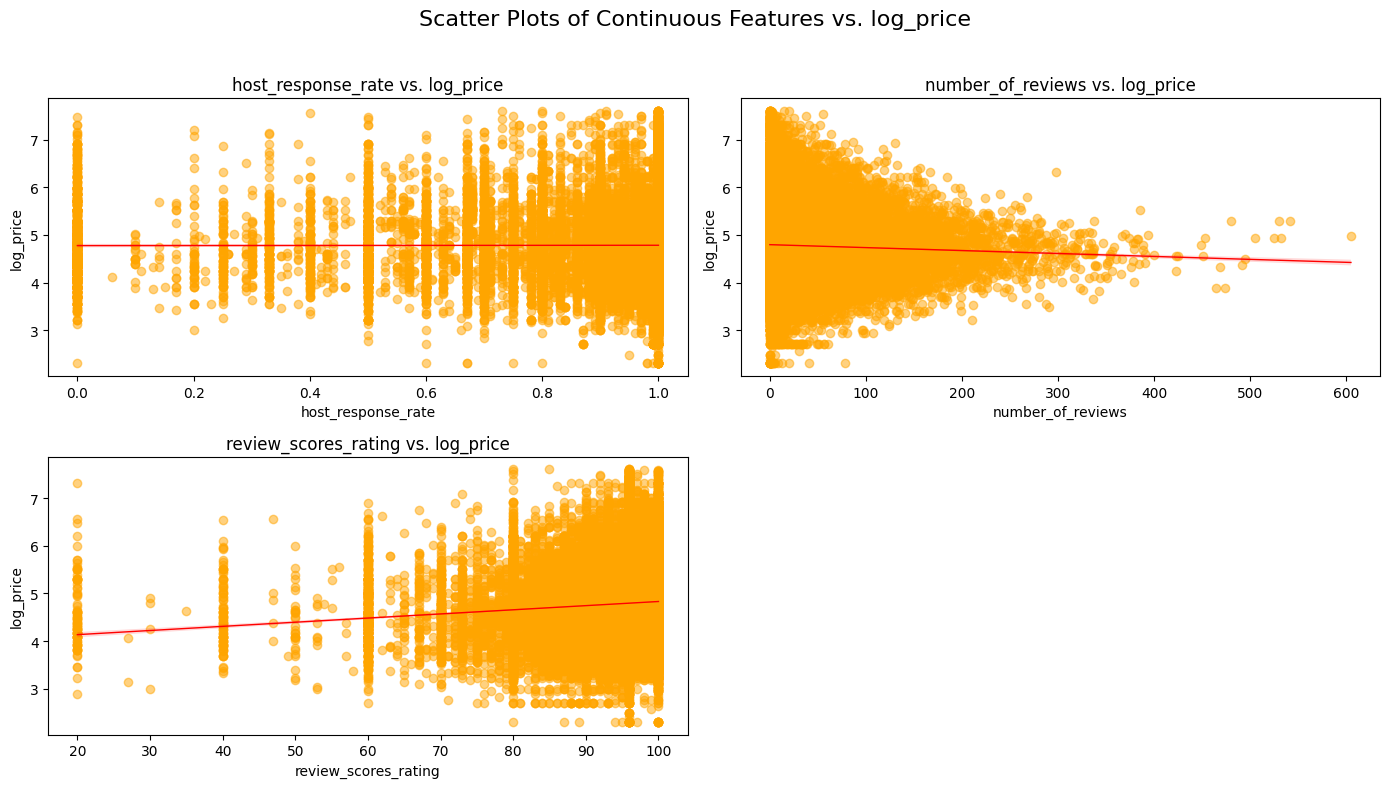

In [44]:
continuous_features = df.select_dtypes(include=['float64', 'int64']).columns.difference(['log_price', 'bedrooms', 'bathrooms', 'beds', 'accommodates', 'latitude', 'longitude'])

n_cols = 2
n_rows = (len(continuous_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
fig.suptitle('Scatter Plots of Continuous Features vs. log_price', fontsize=16)

axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    sns.regplot(
        x=df[feature], y=df['log_price'], ax=axes[i], 
        scatter_kws={'color': 'orange', 'alpha': 0.5},
        line_kws={'color': 'red', 'linewidth': 1}
    )
    axes[i].set_title(f'{feature} vs. log_price')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])

* Host Response Rate and Price: The host response rate does not significantly explain changes in price.
* Number of Reviews and Price: As the number of reviews increases, the price declines at a very gradual rate.
* Review Score and Price: As the review score increases, the price rises gradually.
* However, the overall relationship between continuous numerical features and target variable doesn't look clear.

### 2.2.3 Categorical features vs target variable

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74109 entries, 0 to 74110
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   log_price               74109 non-null  float64       
 1   property_type           74109 non-null  object        
 2   room_type               74109 non-null  category      
 3   amenities               74109 non-null  object        
 4   accommodates            74109 non-null  int64         
 5   bathrooms               74109 non-null  float64       
 6   cancellation_policy     74109 non-null  category      
 7   cleaning_fee            74109 non-null  bool          
 8   city                    74109 non-null  category      
 9   description             74109 non-null  object        
 10  host_identity_verified  74109 non-null  category      
 11  host_response_rate      74109 non-null  float64       
 12  host_since              74109 non-null  dateti

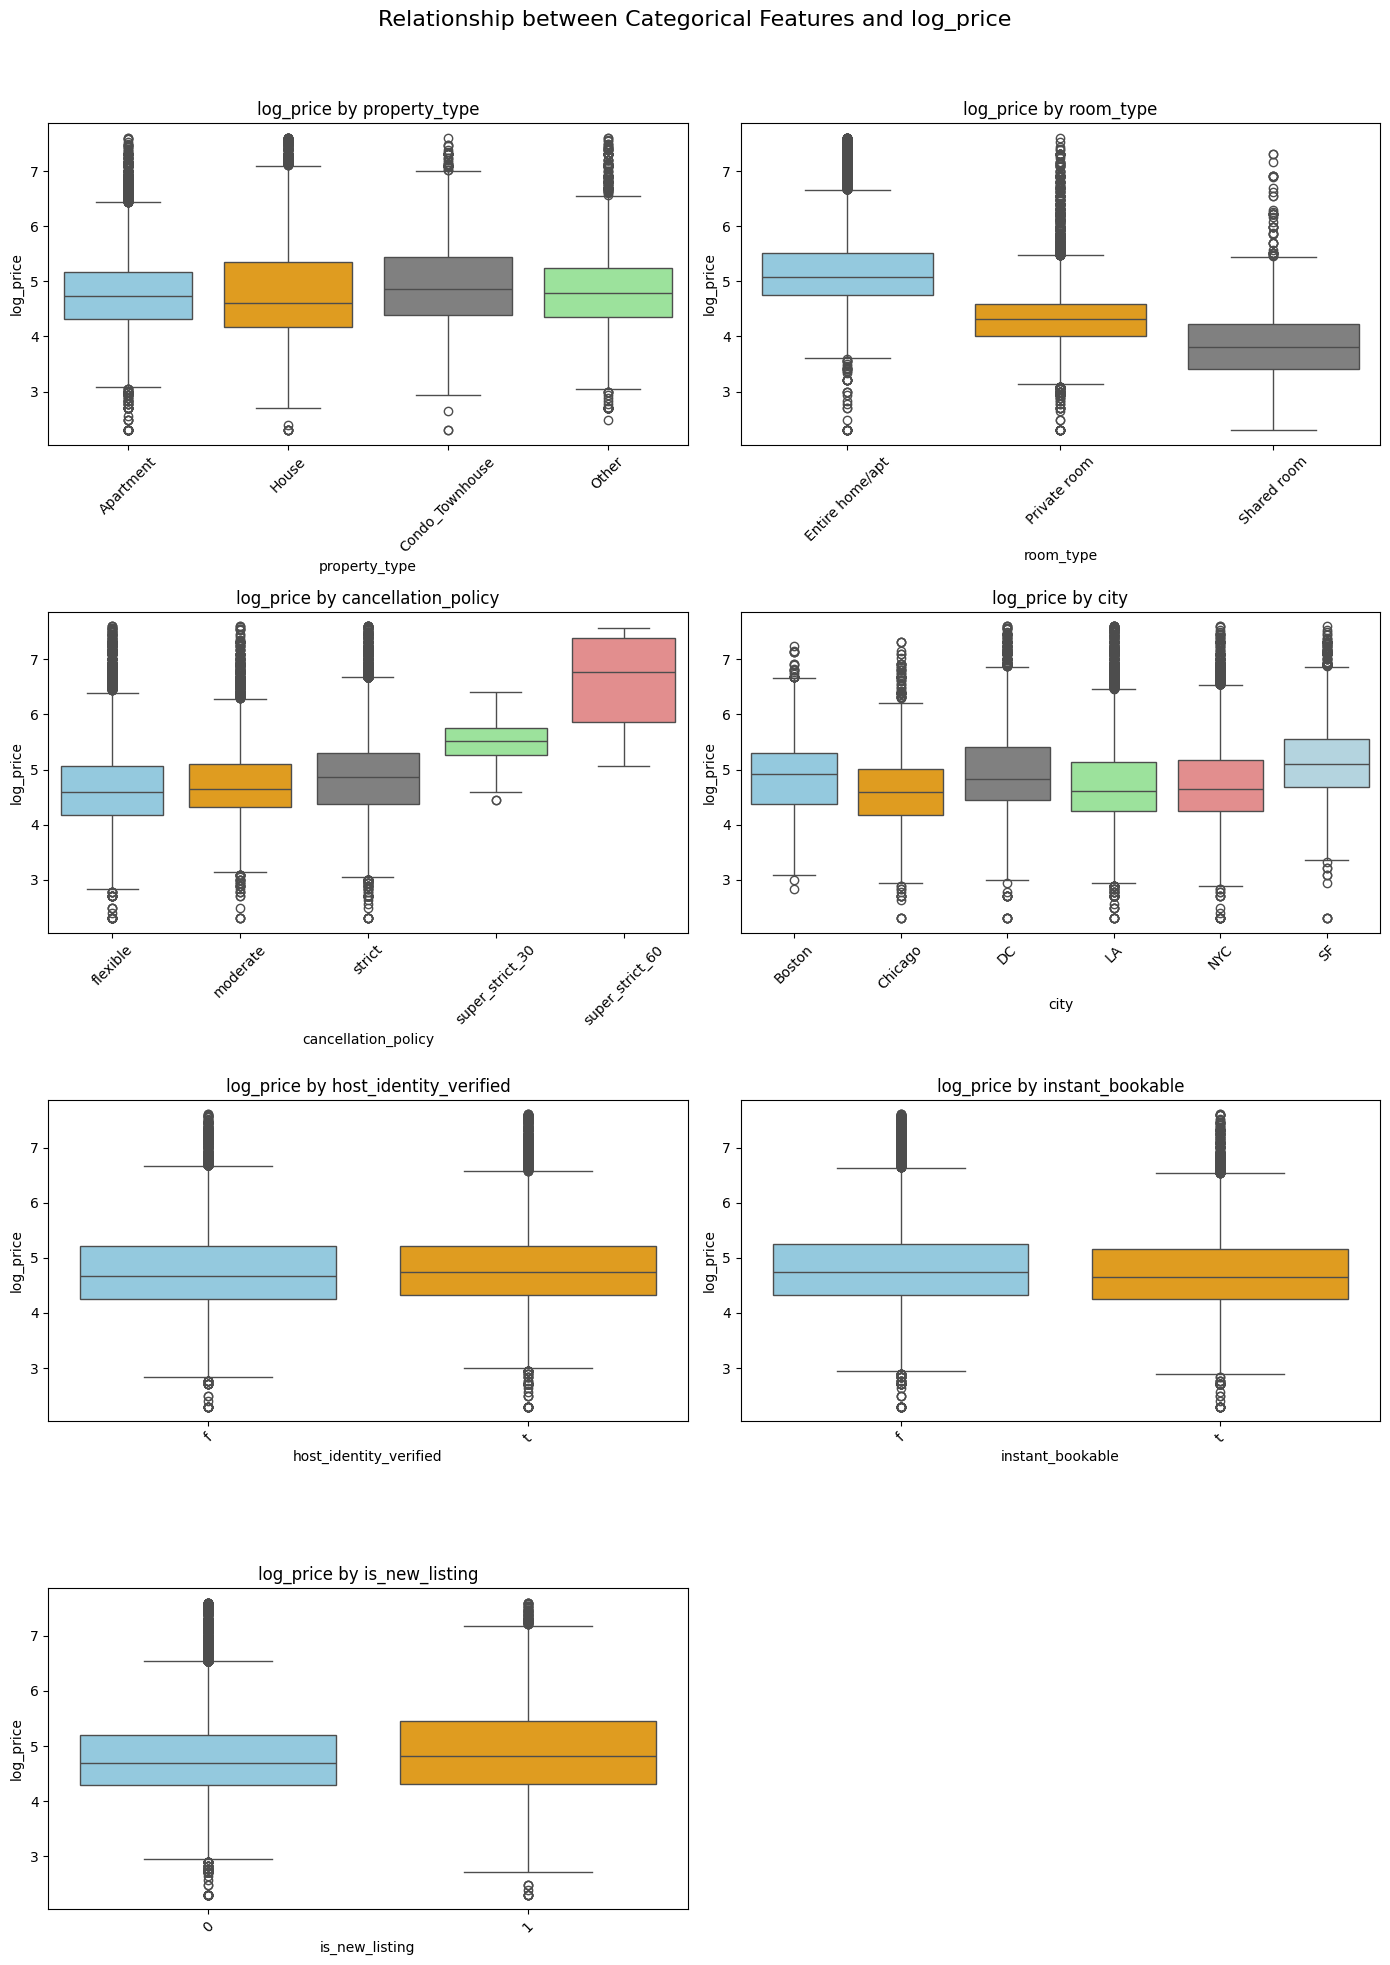

In [46]:
custom_palette = ['skyblue', 'orange', 'gray', 'lightgreen', 'lightcoral', 'lightblue', 'yellow']

categorical_features = ['property_type', 'room_type', 'cancellation_policy', 
                        'city', 'host_identity_verified', 'instant_bookable', 'is_new_listing']

n_cols = 2
n_rows = (len(categorical_features) + n_cols - 1) // n_cols  # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
fig.suptitle('Relationship between Categorical Features and log_price', fontsize=16)

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.boxplot(data=df, x=feature, y='log_price', ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'log_price by {feature}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])

* The property type has little impact on the price, but room type does; for example, entire homes tend to be priced higher than private or shared rooms. 
* Listings with a stricter cancellation policy are also generally more expensive. 
* By city, San Francisco, DC, and Boston have the highest prices, followed by the other cities. 
* Other features show smaller price differences; however, properties that are not instantly bookable tend to be slightly more expensive, and newly listed properties also have a marginally higher price than older listings.

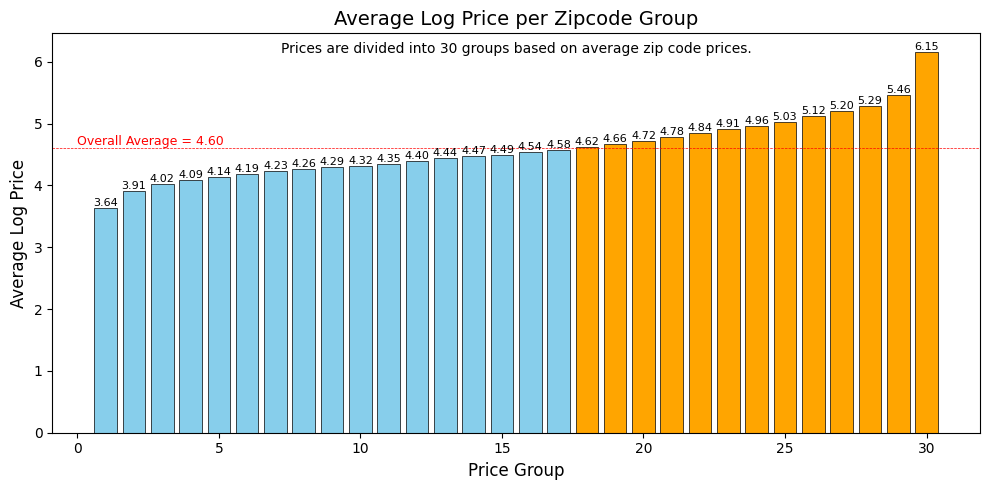

In [47]:
zipcode_avg_price = df.groupby('zipcode')['log_price'].mean().reset_index()
zipcode_avg_price = zipcode_avg_price.sort_values('log_price', ascending=False)
zipcode_avg_price['price_group'] = pd.qcut(zipcode_avg_price['log_price'], 30, labels=False) + 1
group_avg_prices = zipcode_avg_price.groupby('price_group')['log_price'].mean().reset_index()
overall_avg_price = group_avg_prices['log_price'].mean()

plt.figure(figsize=(10, 5))

bar_colors = ['skyblue' if x < overall_avg_price else 'orange' for x in group_avg_prices['log_price']]

bars = plt.bar(group_avg_prices['price_group'], group_avg_prices['log_price'], 
               color=bar_colors, edgecolor='black', linewidth=0.5)

for i, v in enumerate(group_avg_prices['log_price']):
    plt.text(group_avg_prices['price_group'].iloc[i], v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.axhline(y=overall_avg_price, color='red', linestyle='--', linewidth=0.5)

plt.text(0, overall_avg_price, f'Overall Average = {overall_avg_price:.2f}', 
         color='red', ha='left', va='bottom', fontsize=9)

plt.title('Average Log Price per Zipcode Group', fontsize=14)
plt.xlabel('Price Group', fontsize=12)
plt.ylabel('Average Log Price', fontsize=12)

plt.annotate('Prices are divided into 30 groups based on average zip code prices.',
             xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')

plt.tight_layout()

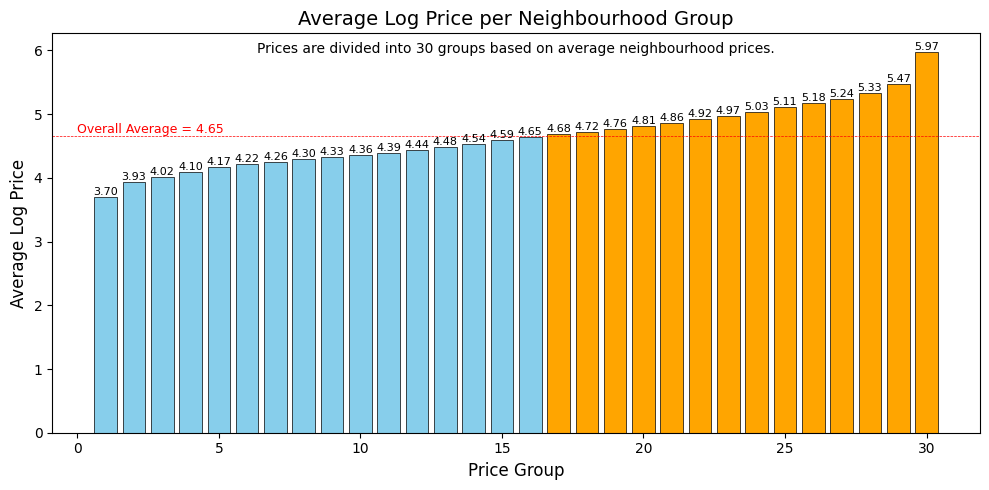

In [48]:
neighbourhood_avg_price = df.groupby('neighbourhood')['log_price'].mean().reset_index()
neighbourhood_avg_price = neighbourhood_avg_price.sort_values('log_price', ascending=False)
neighbourhood_avg_price['price_group'] = pd.qcut(neighbourhood_avg_price['log_price'], 30, labels=False) + 1
group_avg_prices = neighbourhood_avg_price.groupby('price_group')['log_price'].mean().reset_index()
overall_avg_price = group_avg_prices['log_price'].mean()

plt.figure(figsize=(10, 5))

bar_colors = ['skyblue' if x < overall_avg_price else 'orange' for x in group_avg_prices['log_price']]

bars = plt.bar(group_avg_prices['price_group'], group_avg_prices['log_price'], 
               color=bar_colors, edgecolor='black', linewidth=0.5)

for i, v in enumerate(group_avg_prices['log_price']):
    plt.text(group_avg_prices['price_group'].iloc[i], v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.axhline(y=overall_avg_price, color='red', linestyle='--', linewidth=0.5)

plt.text(0, overall_avg_price, f'Overall Average = {overall_avg_price:.2f}', 
         color='red', ha='left', va='bottom', fontsize=9)

plt.title('Average Log Price per Neighbourhood Group', fontsize=14)
plt.xlabel('Price Group', fontsize=12)
plt.ylabel('Average Log Price', fontsize=12)

plt.annotate('Prices are divided into 30 groups based on average neighbourhood prices.',
             xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='black')

plt.tight_layout()

* As we examine the average prices by zipcode and neighborhood groups, we can see that both higher and lower price groups show greater fluctuations in price.

## 2.3 Interaction Effects

### 2.3.1 Interaction between categorical and non-continuous numerical features

#### 2.3.1.1 Interaction between room type and accommodates, bedrooms, bathrooms

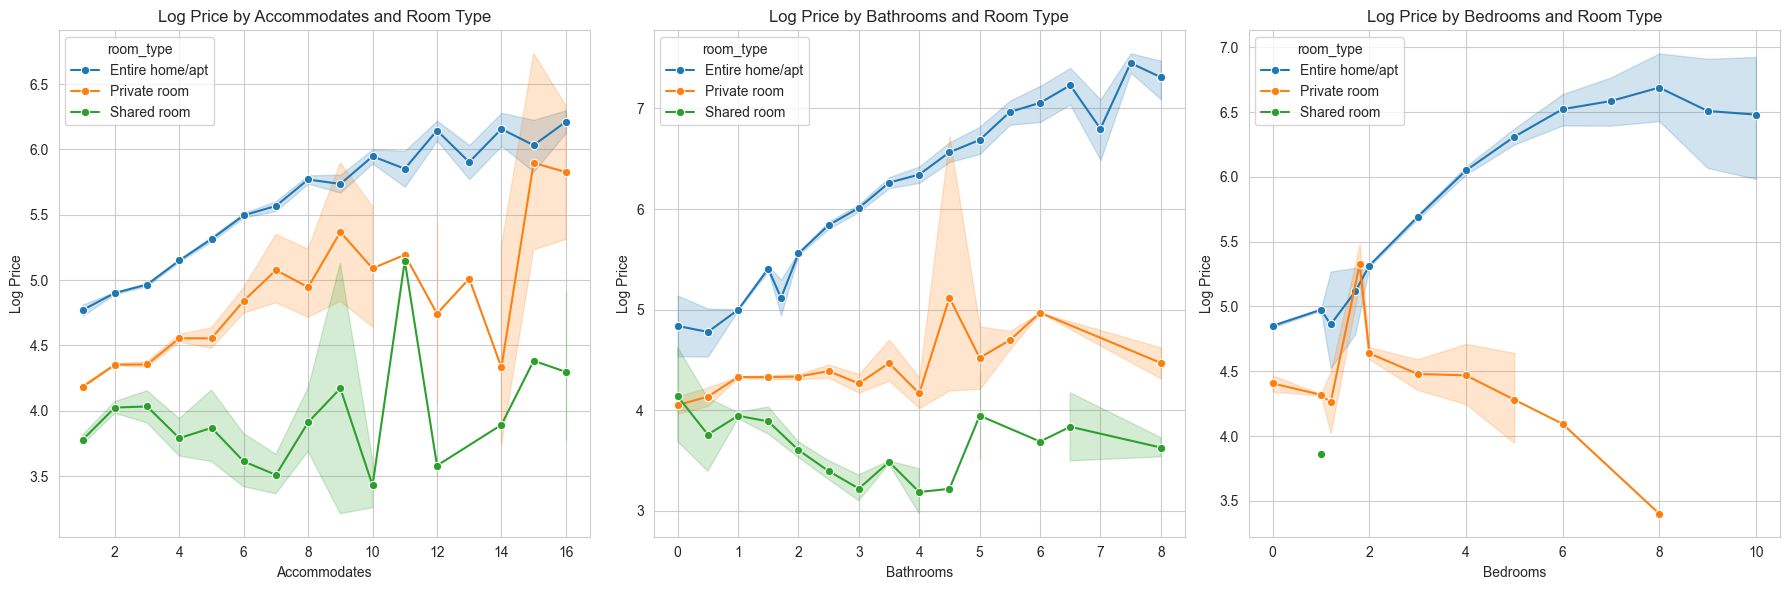

In [49]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.lineplot(data=df, x='accommodates', y='log_price', hue='room_type', marker='o')
plt.title("Log Price by Accommodates and Room Type")
plt.xlabel("Accommodates")
plt.ylabel("Log Price")

plt.subplot(1, 3, 2)
sns.lineplot(data=df, x='bathrooms', y='log_price', hue='room_type', marker='o')
plt.title("Log Price by Bathrooms and Room Type")
plt.xlabel("Bathrooms")
plt.ylabel("Log Price")

plt.subplot(1, 3, 3)
sns.lineplot(data=df, x='bedrooms', y='log_price', hue='room_type', marker='o')
plt.title("Log Price by Bedrooms and Room Type")
plt.xlabel("Bedrooms")
plt.ylabel("Log Price")


plt.tight_layout()

* Accommodates, bedrooms, and bathrooms all show different price trends based on room type, indicating an interaction.

#### 2.3.1.2 Interaction between city and accommodates, bedrooms, bathrooms

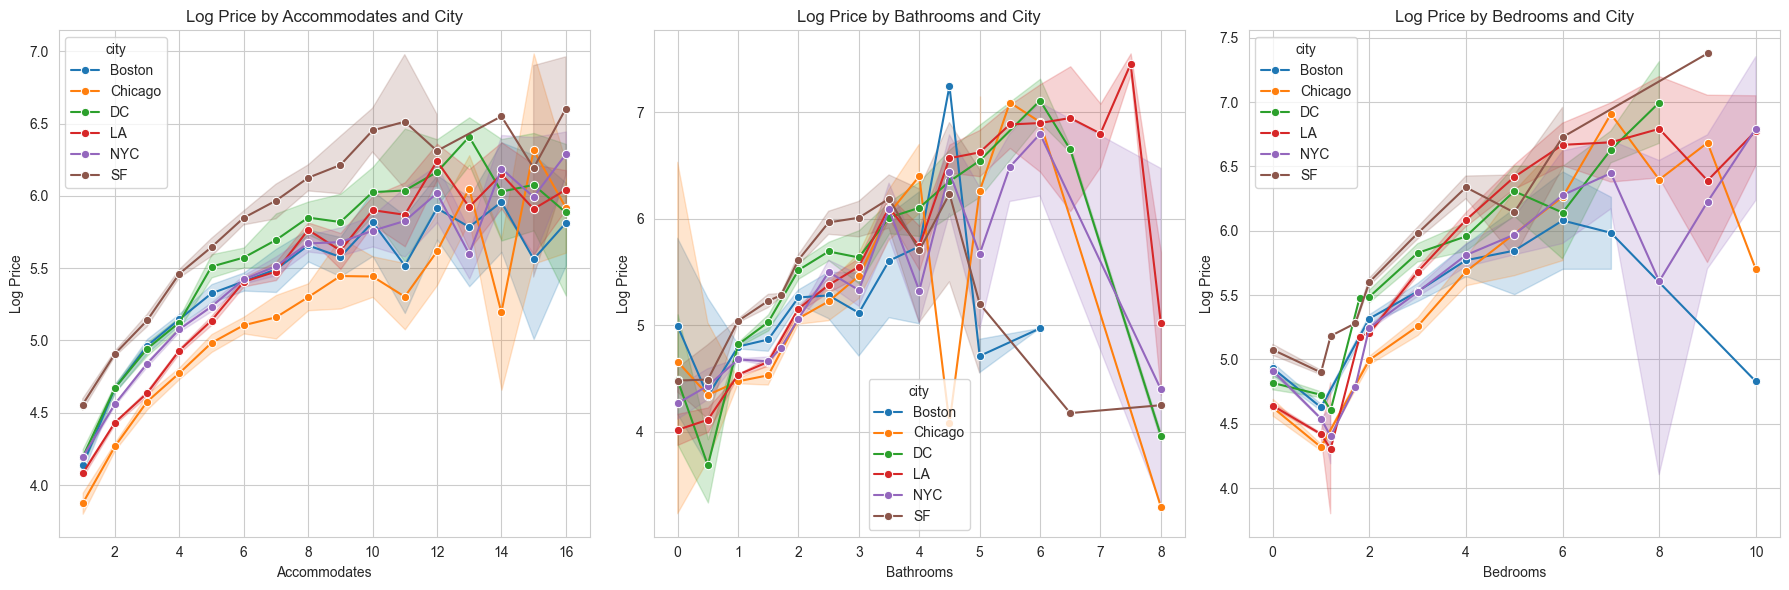

In [50]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.lineplot(data=df, x='accommodates', y='log_price', hue='city', marker='o')
plt.title("Log Price by Accommodates and City")
plt.xlabel("Accommodates")
plt.ylabel("Log Price")

plt.subplot(1, 3, 2)
sns.lineplot(data=df, x='bathrooms', y='log_price', hue='city', marker='o')
plt.title("Log Price by Bathrooms and City")
plt.xlabel("Bathrooms")
plt.ylabel("Log Price")

plt.subplot(1, 3, 3)
sns.lineplot(data=df, x='bedrooms', y='log_price', hue='city', marker='o')
plt.title("Log Price by Bedrooms and City")
plt.xlabel("Bedrooms")
plt.ylabel("Log Price")


plt.tight_layout()

* There seems to be no interaction between the city and the three numerical variables (accommodates, bathrooms, bedrooms), as there is no significant difference in the slope of log price changes based on variations in these variables across different cities.

#### 2.3.1.3 Interaction between host ID verification and accommodates, bedrooms, bathrooms

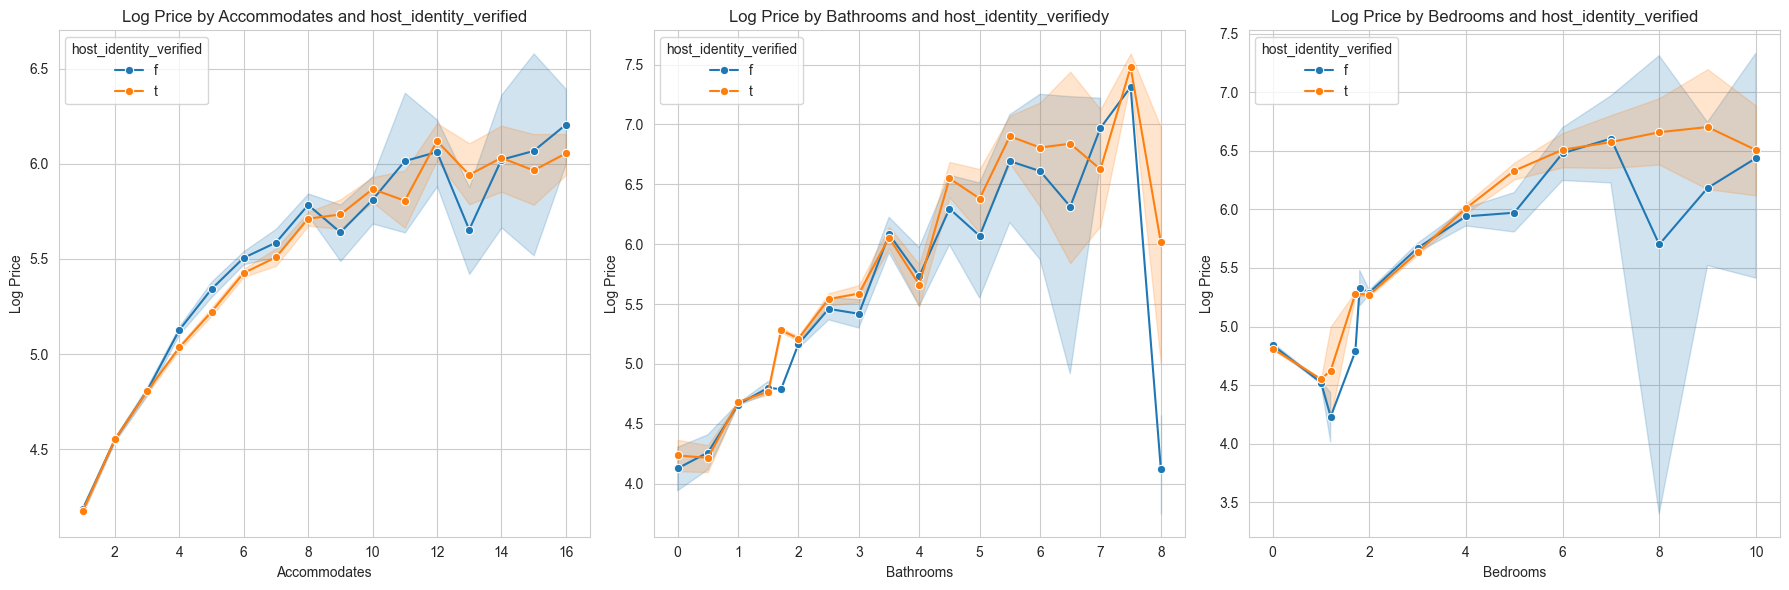

In [51]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.lineplot(data=df, x='accommodates', y='log_price', hue='host_identity_verified', marker='o')
plt.title("Log Price by Accommodates and host_identity_verified")
plt.xlabel("Accommodates")
plt.ylabel("Log Price")

plt.subplot(1, 3, 2)
sns.lineplot(data=df, x='bathrooms', y='log_price', hue='host_identity_verified', marker='o')
plt.title("Log Price by Bathrooms and host_identity_verifiedy")
plt.xlabel("Bathrooms")
plt.ylabel("Log Price")

plt.subplot(1, 3, 3)
sns.lineplot(data=df, x='bedrooms', y='log_price', hue='host_identity_verified', marker='o')
plt.title("Log Price by Bedrooms and host_identity_verified")
plt.xlabel("Bedrooms")
plt.ylabel("Log Price")


plt.tight_layout()

* No interaction

### 2.3.1.4 Interaction between instant bookability and accommodates, bedrooms, bathrooms

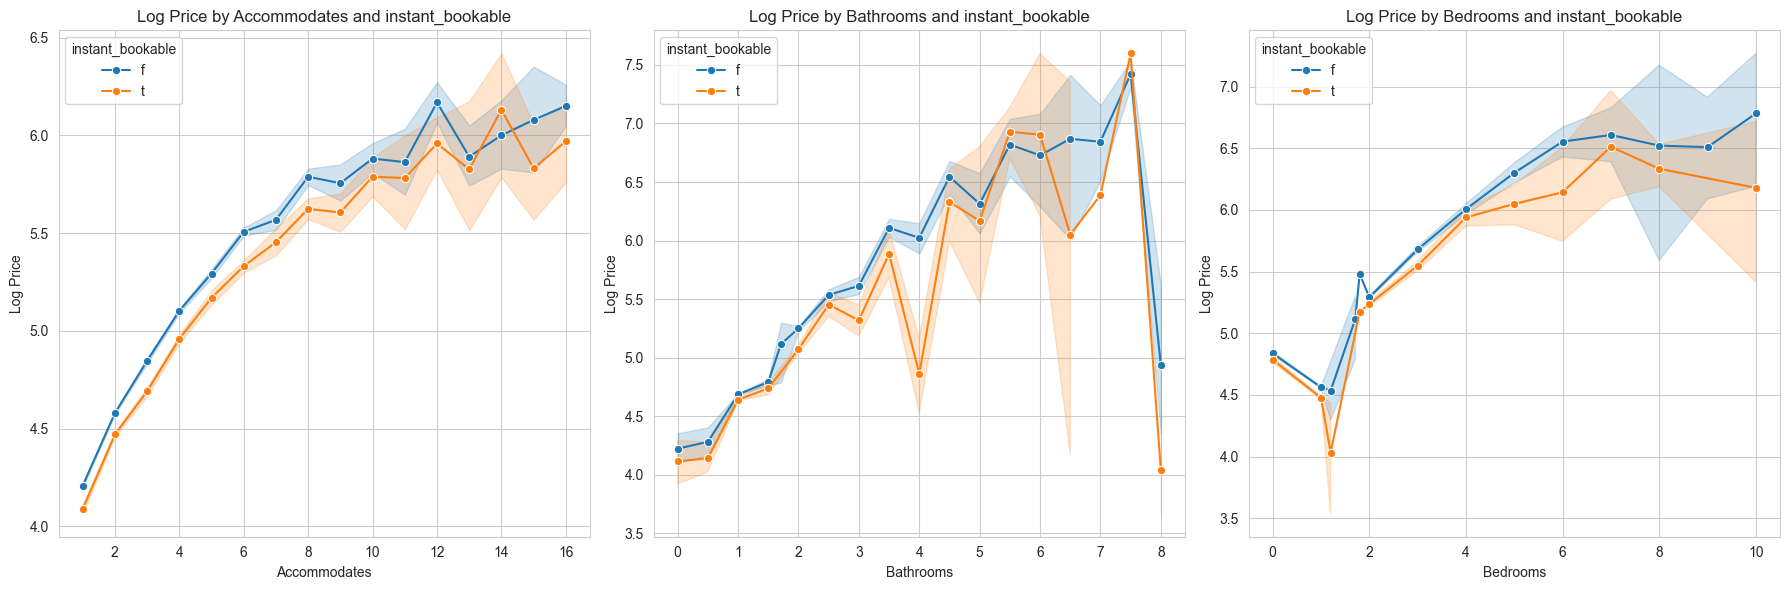

In [52]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.lineplot(data=df, x='accommodates', y='log_price', hue='instant_bookable', marker='o')
plt.title("Log Price by Accommodates and instant_bookable")
plt.legend(title='instant_bookable')
plt.xlabel("Accommodates")
plt.ylabel("Log Price")

plt.subplot(1, 3, 2)
sns.lineplot(data=df, x='bathrooms', y='log_price', hue='instant_bookable', marker='o')
plt.title("Log Price by Bathrooms and instant_bookable")
plt.xlabel("Bathrooms")
plt.ylabel("Log Price")

plt.subplot(1, 3, 3)
sns.lineplot(data=df, x='bedrooms', y='log_price', hue='instant_bookable', marker='o')
plt.title("Log Price by Bedrooms and instant_bookable")
plt.xlabel("Bedrooms")
plt.ylabel("Log Price")


plt.tight_layout()

* No interaction

#### 2.3.1.5 Interaction between is_new_listed and accommodates, bedrooms, bathrooms

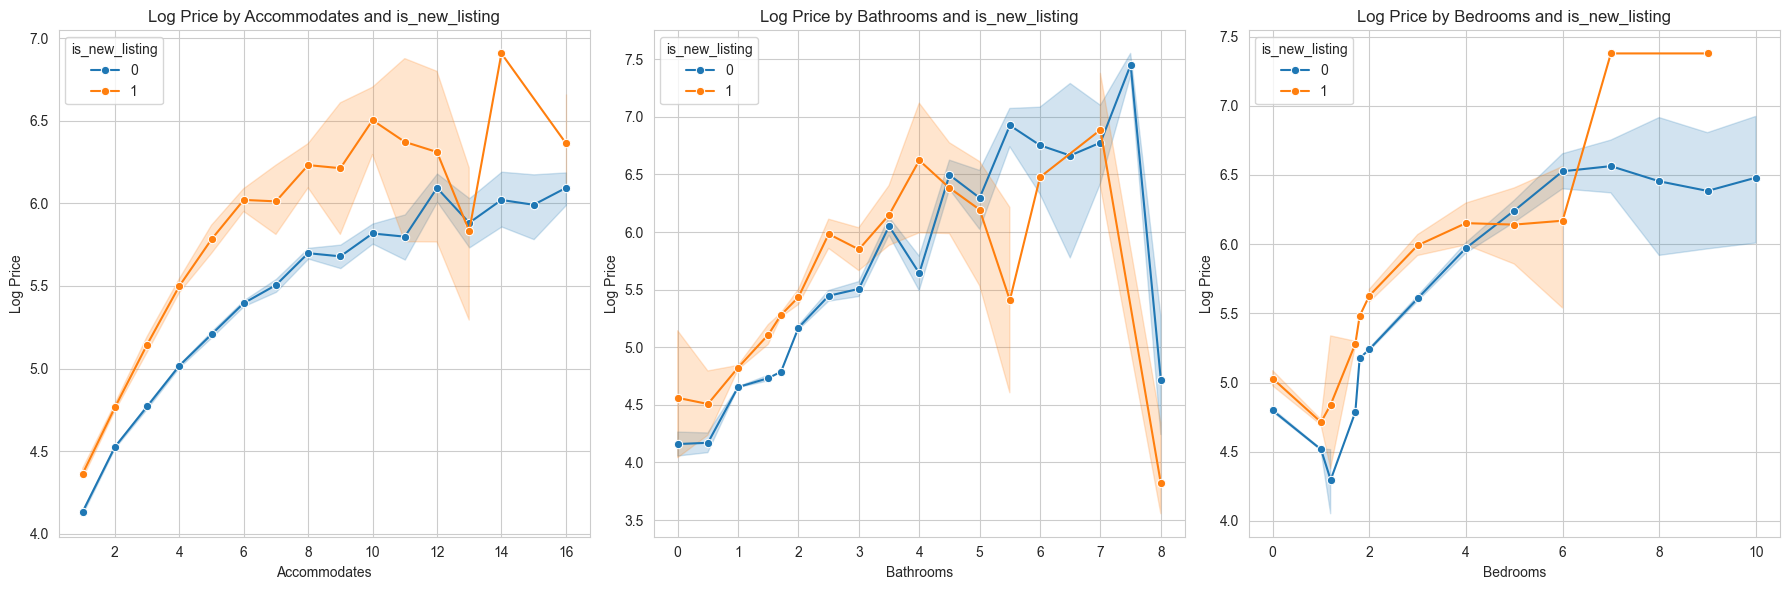

In [53]:
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.lineplot(data=df, x='accommodates', y='log_price', hue='is_new_listing', marker='o')
plt.title("Log Price by Accommodates and is_new_listing")
plt.xlabel("Accommodates")
plt.ylabel("Log Price")

plt.subplot(1, 3, 2)
sns.lineplot(data=df, x='bathrooms', y='log_price', hue='is_new_listing', marker='o')
plt.title("Log Price by Bathrooms and is_new_listing")
plt.xlabel("Bathrooms")
plt.ylabel("Log Price")

plt.subplot(1, 3, 3)
sns.lineplot(data=df, x='bedrooms', y='log_price', hue='is_new_listing', marker='o')
plt.title("Log Price by Bedrooms and is_new_listing")
plt.xlabel("Bedrooms")
plt.ylabel("Log Price")


plt.tight_layout()

* Accommodates seems to have an interaction with is_new_listing, but the other two variables do not.

* In summary, the three numerical features that have the clearest relationship with the target variable, along with the categorical feature with a clear interaction, which is room type, should have interaction terms created for future analysis.

## 2.4 Outliers

When examining individual numerical variables, it is difficult to determine if they are abnormal. However, cases such as when the bathrooms or beds are 0 may indicate data entry errors, so these rows should be removed from the dataset. Next, outliers will be identified and handled based on relationships between variables. Specifically, records where the ratio of accommodates to bedrooms, or the ratio of bathrooms to bedrooms, is unusually high or low should be removed from the dataset.

In [54]:
# Remove rows where 'bathrooms' or 'bedrooms' is 0
df = df[(df['bathrooms'] != 0) & (df['beds'] != 0)]

# Calculate the 'accommodates_to_bedrooms' ratio, only when both 'accommodates' and 'bedrooms' are non-zero
df['accommodates_to_bedrooms'] = np.where((df['accommodates'] != 0) & (df['bedrooms'] != 0),
                                           df['accommodates'] / df['bedrooms'], 0)

# Calculate the 'bathrooms_to_bedrooms' ratio, only when both 'bathrooms' and 'bedrooms' are non-zero
df['bathrooms_to_bedrooms'] = np.where((df['bathrooms'] != 0) & (df['bedrooms'] != 0),
                                       df['bathrooms'] / df['bedrooms'], 0)

# Calculate the z-scores for the two ratios
df['accommodates_to_bedrooms_zscore'] = zscore(df['accommodates_to_bedrooms'])
df['bathrooms_to_bedrooms_zscore'] = zscore(df['bathrooms_to_bedrooms'])

In [55]:
# Remove rows where the z-score of the ratios is greater than 3 or less than -3
df = df[(np.abs(df['accommodates_to_bedrooms_zscore']) < 3) & 
        (np.abs(df['bathrooms_to_bedrooms_zscore']) < 3)]

df.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,description,...,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,is_new_listing,accommodates_to_bedrooms,bathrooms_to_bedrooms,accommodates_to_bedrooms_zscore,bathrooms_to_bedrooms_zscore
0,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",...,2,100.0,11201,1.0,1.0,0,3.000000,1.000000,0.721286,0.202869
1,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,...,6,93.0,10019,3.0,3.0,0,2.333333,0.333333,0.176456,-1.214770
2,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,moderate,True,NYC,The Oasis comes complete with a full backyard ...,...,10,92.0,10027,1.0,3.0,0,5.000000,1.000000,2.355777,0.202869
3,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,flexible,True,SF,This light-filled home-away-from-home is super...,...,0,96.0,94117,2.0,2.0,1,2.000000,0.500000,-0.095959,-0.860360
4,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",...,4,40.0,20009,0.0,1.0,0,0.000000,0.000000,-1.730451,-1.923590


In [56]:
df.drop(columns=['accommodates_to_bedrooms', 'bathrooms_to_bedrooms', 'accommodates_to_bedrooms_zscore', 'bathrooms_to_bedrooms_zscore'], inplace=True)

In [57]:
df.to_csv('data\df_cleaned.csv')